# Setting

## Environmental Setting

In [1]:
# Anal Env.
import pandas as pd
import numpy  as np
import os
import re
import datetime
import pytz
import copy
from collections import Counter
from emoji       import UNICODE_EMOJI
from functools   import reduce
import operator
import time


import sys
sys.path.append('/home/handeully/')
# GCP Env.
import bigquery_etl as bq


# NLP Env.
import nltk
from nltk import FreqDist
from nltk.corpus   import stopwords
from nltk.tokenize import regexp_tokenize
from nltk.stem     import WordNetLemmatizer,PorterStemmer,LancasterStemmer
from nltk.corpus   import wordnet
from nltk.corpus   import sentiwordnet as swn
from nltk import sent_tokenize, word_tokenize, pos_tag


# stop_words = stopwords.words('english')
import spacy
import gensim
from gensim import corpora
import ray
import psutil
from tqdm.notebook import tqdm


#glove
from glove import Corpus, Glove


# Vis Env.
import pyLDAvis
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


# Coding Env.
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


# Multi-Core related... 
# #initialization ray
# import ray
# ray.init(ignore_reinit_error=True,num_cpus=5)

import collections

# Model Env.
# model save
import pickle
import joblib
# tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import * # SimpleRNN, Embedding, Dense
from tensorflow.keras.models import Sequential
# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
# SGD Classification
from sklearn.linear_model import SGDClassifier
# Train-Test Split
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, multilabel_confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve, mean_squared_error
import itertools
from sklearn.preprocessing import OneHotEncoder
# Earliy-Stopping
from keras.callbacks import EarlyStopping
# modle-plot
# from keras.utils import plot_model

# confusion matrix visualization
import matplotlib.font_manager as fm
from matplotlib.collections import QuadMesh
from sklearn.metrics import classification_report, plot_confusion_matrix,confusion_matrix,accuracy_score

## Define Function

In [2]:
# Load Data FROM Big Query(db connection)
def convert_lowercase(df):
    df_1 =  df.apply(lambda x: x.astype(str).str.lower() if(x.dtype == 'object') else x)
    return df_1


#check multiprocessing progress 
def to_iterator(obj_ids):
    while obj_ids:
        done, obj_ids = ray.wait(obj_ids)
        yield ray.get(done[0])


# !!!! @@@@@@@@@ TEAMS Check First @@@@@@@@@ !!!! 
# def ray_multiprocessing_progress(ray_df):
#     for x in tqdm(to_iterator(ray_df), total=len(ray_df)):
#         pass
#     ray_df  = pd.concat(ray.get(ray_df))
#     return ray_df


# pre-processing for review text
def preprocess_review(rvw):
    # Remove punctuations and numbers
    review = re.sub('[^a-zA-Z]', ' ', rvw)
    # Single character removal
    review = re.sub(r"\s+[a-zA-Z]\s+", ' ', review)
    # Removing multiple spaces
    review = re.sub(r'\s+', ' ', review)
    return review

def preprocess_stpwds(rvw, stop_words) : 
    rs = []
    for r in rvw.split(" ") : 
        if (r not in stop_words) and (len(r) > 0) : rs.append(r)
    return " ".join(rs)


# Multi-Label Model, Threshold
def calculate_optimal_threshold(y_true, y_pred_cls):
    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_cls)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC Curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlim([-0.025, 1.025])
    plt.ylim([-0.025, 1.025])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('RoC Curve')
    print("AUC: ", roc_auc)
    
    # Calculate the optimal threshold
    i = np.arange(len(tpr)) # index for df
    roc_df = pd.DataFrame({'threshold' : pd.Series(thresholds, index = i), 
                           'fpr': pd.Series(fpr, index=i), 
                           '1-fpr' : pd.Series(1-fpr, index = i), 
                           'tpr': pd.Series(tpr, index = i), 
                           'diff': pd.Series(tpr - (1-fpr), index = i) })
    opt_threshold = roc_df.iloc[roc_df['diff'].abs().argsort()[:1]]
    print(opt_threshold)
    
    return opt_threshold['threshold'].values[0]

# Confusion Matrix
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Greens):
    fig, ax = plt.subplots(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    plt.colorbar()
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
    	cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    	plt.text(j, i, round(cm[i, j], 2), fontsize=10, horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
#imports
import matplotlib.font_manager as fm
from matplotlib.collections import QuadMesh


def get_new_fig(fn, figsize=[20,20]):
    fig1 = plt.figure(fn, figsize)
    ax1 = fig1.gca()   #Get Current Axis
    ax1.cla() # clear existing plot
    return fig1, ax1


def configcell_text_and_colors(array_df, lin, col, oText, facecolors, posi, fz, fmt, show_null_values=0):
    text_add = []; text_del = [];
    cell_val = array_df[lin][col]
    tot_all = array_df[-1][col]
#     print(f'tot all:{tot_all}')
#     print(f'cell val:{cell_val}')
    per = round((float(cell_val) / tot_all) * 100,1)
    curr_column = array_df[:,col]
    ccl = len(curr_column)

    #last line  and/or last column
    if(col == (ccl - 1)) or (lin == (ccl - 1)):
        #tots and percents
        if(tot_all != 0):
            if(col == ccl - 1) and (lin == ccl - 1):
                tot_rig = 0
                for i in range(array_df.shape[0] - 1):
                    tot_rig += array_df[i][i]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif(col == ccl - 1):
                tot_rig = array_df[lin][lin]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif(lin == ccl - 1):
                tot_rig = array_df[col][col]
                per_ok = (float(tot_rig) / cell_val) * 100
            per_ok = round(per_ok,1)
            per_err = 100 - per_ok
        else:
            per_ok = per_err = 0

        per_ok_s = ['%.1f%%'%(per_ok), '100%'] [per_ok == 100]

        #text to DEL
        text_del.append(oText)

        #text to ADD
        font_prop = fm.FontProperties(weight='bold', size=fz)
        text_kwargs = dict(color='w', ha="center", va="center", gid='sum', fontproperties=font_prop)
        lis_txt = ['%d'%(cell_val), per_ok_s, '%.1f%%'%(per_err)]
        lis_kwa = [text_kwargs]
        dic = text_kwargs.copy(); dic['color'] = 'g'; lis_kwa.append(dic);
        dic = text_kwargs.copy(); dic['color'] = 'r'; lis_kwa.append(dic);
        lis_pos = [(oText._x, oText._y-0.3), (oText._x, oText._y), (oText._x, oText._y+0.3)]
        for i in range(len(lis_txt)):
            newText = dict(x=lis_pos[i][0], y=lis_pos[i][1], text=lis_txt[i], kw=lis_kwa[i])
            #print 'lin: %s, col: %s, newText: %s' %(lin, col, newText)
            text_add.append(newText)
        #print '\n'

        #set background color for sum cells (last line and last column)
        carr = [0.27, 0.30, 0.27, 1.0]
        if(col == ccl - 1) and (lin == ccl - 1):
            carr = [0.17, 0.20, 0.17, 1.0]
        facecolors[posi] = carr

    else:
        if(per > 0):
            txt = '%s\n%.1f%%' %(cell_val, per)
        else:
            if(show_null_values == 0):
                txt = ''
            elif(show_null_values == 1):
                txt = '0'
            else:
                txt = '0\n0.0%'
        oText.set_text(txt)

        #main diagonal
        if(col == lin):
            #set color of the textin the diagonal to white
            oText.set_color('w')
            # set background color in the diagonal to blue
            facecolors[posi] = [0.35, 0.8, 0.55, 1.0]
        else:
            oText.set_color('r')

    return text_add, text_del
#

def insert_totals(df_cm):
    """ insert total column and line (the last ones) """
    sum_col = []
    for c in df_cm.columns:
        sum_col.append( df_cm[c].sum() )
    sum_lin = []
    for item_line in df_cm.iterrows():
        sum_lin.append( item_line[1].sum() )
    df_cm['sum_lin'] = sum_lin
    sum_col.append(np.sum(sum_lin))
    df_cm.loc['sum_col'] = sum_col
    #print ('\ndf_cm:\n', df_cm, '\n\b\n')
#

def pretty_plot_confusion_matrix(df_cm, annot=True, cmap="Oranges", fmt='.1f', fz=14,
      lw=0.5, cbar=False, figsize=[15,15], show_null_values=0, pred_val_axis='y',title = 'Confusion matrix'):
    if(pred_val_axis in ('col', 'x')):
        xlbl = 'Predicted'
        ylbl = 'Actual'
    else:
        xlbl = 'Actual'
        ylbl = 'Predicted'
        df_cm = df_cm.T

    # create "Total" column
    insert_totals(df_cm)

    #this is for print allways in the same window
    fig, ax1 = get_new_fig('Conf matrix default', figsize)

    #thanks for seaborn
    ax = sns.heatmap(df_cm, annot=annot, annot_kws={"size": fz}, linewidths=lw, ax=ax1,
                    cbar=cbar, cmap=cmap, linecolor='w', fmt=fmt)

    #set ticklabels rotation
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, fontsize = 15)
    ax.set_yticklabels(ax.get_yticklabels(), rotation = 25, fontsize = 15)

    # Turn off all the ticks
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    #face colors list
    quadmesh = ax.findobj(QuadMesh)[0]
    facecolors = quadmesh.get_facecolors()

    #iter in text elements
    array_df = np.array( df_cm.to_records(index=False).tolist() )
    text_add = []; text_del = [];
    posi = -1 #from left to right, bottom to top.
    for t in ax.collections[0].axes.texts: #ax.texts:
        pos = np.array( t.get_position()) - [0.5,0.5]
        lin = int(pos[1]); 
        col = int(pos[0]);
        posi += 1
        #print ('>>> pos: %s, posi: %s, val: %s, txt: %s' %(pos, posi, array_df[lin][col], t.get_text()))

        #set text
        txt_res = configcell_text_and_colors(array_df, lin, col, t, facecolors, posi, fz, fmt, show_null_values)

        text_add.extend(txt_res[0])
        text_del.extend(txt_res[1])

    #remove the old ones
    for item in text_del:
        item.remove()
    #append the new ones
    for item in text_add:
        ax.text(item['x'], item['y'], item['text'], **item['kw'])

    #titles and legends
    ax.set_title(title, fontsize=18)
    ax.set_xlabel(xlbl, fontsize=15)
    ax.set_ylabel(ylbl, fontsize=15)
    plt.tight_layout()  #set layout slim
    plt.show()
    fig.savefig('210629_confusion_matrix.jpg')
#

def plot_confusion_matrix_from_data(y_test, predictions, columns=None, annot=True, cmap="Oranges",
      fmt='.1f', fz=11, lw=0.5, cbar=False, figsize=[8,8], show_null_values=0, pred_val_axis='lin'):
    
    from sklearn.metrics import confusion_matrix
    from datetime import date

    today = date.today()
    # dd/mm/YY
    d1 = today.strftime("%Y%m%d")

    #data
    if(not columns):
        #labels axis integer:
        ##columns = range(1, len(np.unique(y_test))+1)
        #labels axis string:
        from string import ascii_uppercase
        columns = ['class %s' %(i) for i in list(ascii_uppercase)[0:len(np.unique(y_test))]]

    confm = confusion_matrix(y_test, predictions)
    cmap = 'Oranges';
    fz = 13;
    figsize=[20,20];
    show_null_values = 2
    df_cm = pd.DataFrame(confm, index=columns, columns=columns)
    title = 'Confusion Matrix(%s)'%(str(d1))
    pretty_plot_confusion_matrix(df_cm, fz=fz, cmap=cmap, figsize=figsize, show_null_values=show_null_values, pred_val_axis=pred_val_axis,title = title)
#

def _execute_confusion_matrix(y_test,y_pred):
    y_test = y_test
    predic = y_pred

    columns = target_name
    annot = True;
    cmap = 'Oranges';
    fmt = '.2f'
    lw = 0.5
    cbar = False
    show_null_values = 2
    pred_val_axis = 'y'
    fz = 12;
    figsize = [15,15];
    if(len(y_test) > 10):
        fz=9; figsize=[20,20];
    plot_confusion_matrix_from_data(y_test, predic, columns,
      annot, cmap, fmt, fz, lw, cbar, figsize, show_null_values, pred_val_axis)

<br>
====================================================================================
<br>

# Data Load, EDA, Pre-processing

## Shinning Review Data Load

In [4]:
# get shining review data from DB
sql = '''
    SELECT *
    FROM taxonomy.shng_rvw
'''
org_shn_df = bq.select_query(sql)
org_shn_df.shape

(2702, 13)

In [5]:
shn_df = org_shn_df.copy()

# set 'rv' columns for temp key-value
for i in reversed(range(len(shn_df))) : 
    shn_df.loc[i, 'rv'] = 'shng'+str( shn_df[(shn_df['rv']==shn_df.loc[i].rv) & (shn_df['reviews']==shn_df.loc[i].reviews)].index[0] )

# # Multi-label
shn_df.loc[(shn_df['complimenting_factor']=='Design'), 'class'] = 1
shn_df.loc[(shn_df['complimenting_factor']=='Value'), 'class'] = 2
shn_df.loc[(shn_df['complimenting_factor']=='Assemble'), 'class'] = 3
shn_df.loc[(shn_df['complimenting_factor']=='Packaging'), 'class'] = 4
shn_df.loc[(shn_df['complimenting_factor']=='Quality'), 'class'] = 5
shn_df.loc[(shn_df['complimenting_factor']=='Customer service'), 'class'] = 6
shn_df.loc[(shn_df['complimenting_factor']=='Delivery'), 'class'] = 7
shn_df.loc[(shn_df['complimenting_factor']=='Brand Comparison'), 'class'] = 8
shn_df.loc[(shn_df['complimenting_factor']=='Promised customer'), 'class'] = 9
shn_df.loc[(shn_df['complimenting_factor'].str.contains('Others', na=False)), 'class'] = 10
shn_df.loc[(shn_df['complimenting_factor']=='Shining Review'), 'class'] = 10 # not specified factor, but shinning, anyway
shn_df.loc[(shn_df['complimenting_factor'].isnull()), 'class'] = 10 # null values, but shinning

shn_df.rename(columns = {"rv": "reviewId", "new_ctgr": "new_category", "reviews": "review_text"}, inplace=True)

print(shn_df.shape)
shn_df = shn_df.drop_duplicates()
print(shn_df.shape)
print(len(shn_df['reviewId'].unique()))

shn_df.head()

(2702, 14)
(2699, 14)
1211


,date,by,reviewId,category,sku,product_description,rating,title,review_text,complimenting_factors,ref,complimenting_factor,new_category,class
0,201905,Sophie,shng0,Others,PS-C2824C,"3-Step Easy Pet Stairs, Grey, X- Large",5,Excellent Product,First of all I have 3 60LB dogs whom are welco...,"Design, Quality",None,Design,Others,1.0
1,201905,Sophie,shng0,Others,PS-C2824C,"3-Step Easy Pet Stairs, Grey, X- Large",5,Excellent Product,First of all I have 3 60LB dogs whom are welco...,"Design, Quality",None,Quality,Others,5.0
2,201905,Jennie,shng2,Others,PS-C2824C,"3-Step Easy Pet Stairs, Grey, X- Large",5,Worth the price to save your back!,These stairs are the reason my dog can sleep w...,"Design, Quality",Jennie) Shining Review? - Marshmallow Mountain...,Design,Others,1.0
3,201905,Jennie,shng2,Others,PS-C2824C,"3-Step Easy Pet Stairs, Grey, X- Large",5,Worth the price to save your back!,These stairs are the reason my dog can sleep w...,"Design, Quality",Jennie) Shining Review? - Marshmallow Mountain...,Quality,Others,5.0
4,201904,Jennie,shng4,Others,PS-D2115S,"Pet Stairs Small, Sand",5,Excellent Quality and Price,My chihuahua really loves these steps. He has ...,"Value, Quality",None,Value,Others,2.0


## All Review(2019) Data Load

In [6]:
# get all review data of 2019 from DB
sql2 = '''
    SELECT
        A.*,
        B.prdct_ctgry_4_5 as category,
    FROM
        taxonomy.amz_rvw_all_2019 A
        LEFT JOIN meta.crwl_amz_pdt_mst_all B
        ON A.asin = B.asin
    WHERE 1=1
        AND B.brand = 'Zinus'
        AND A.rating BETWEEN 4 and 5
'''

org_rvw_df = bq.select_query(sql2)

In [7]:
rvw_df = org_rvw_df.copy()

print("Original Review Count :", len(rvw_df))
rvw_df = rvw_df.drop_duplicates()
print("Drop-duplicates Review Count :", len(rvw_df))
rvw_df = rvw_df.sample(n=300)
print("Sample Review Count :", len(rvw_df))

# multi-label
rvw_df['class'] = 0

rvw_df.head()

Original Review Count : 91349
Drop-duplicates Review Count : 91349
Sample Review Count : 300


,reviewId,asin,date,rating,title,review_text,category,brand,category_1,class
3233,R1SOSROSYW9KEM,B00K36K78G,2019-03-19 12:00:00,5,Fabulous,I'm really loving this bed. Was so easy to pu...,Beds,Zinus,Beds,0
19494,R2JVYC3YWPVTZH,B06XGQ66WG,2019-05-08 12:00:00,5,It’s safe and sturdy.,I purchased this so my two Pom’s could get up...,Others,Zinus,Others,0
36403,RUZYMUWZ3EXRU,B01N0OXMF7,2019-12-15 12:00:00,5,"Easy to assemble! Level up to the Elite, it’s ...","Easy assembly, no tools required! I am 5’3” a...",Bed Frames,Zinus,Bed Frames,0
66281,R1SRJUKF3YP1GP,B077S2CXJH,2019-04-18 12:00:00,5,Love it!!,Really happy with this purchase! The way it i...,Beds,Zinus,Beds,0
56099,R17IDGPLTKDTD1,B074TVGW44,2019-09-13 12:00:00,5,Well Made! ... Does the job perfectly!!!! LOVE...,This was beyond well made & very stable & so ...,Bases & Foundations,Zinus,Bases & Foundations,0


In [8]:
# create table -- done.
# bq.insert_query('taxonomy.amz_rvw_all_2019', rvw_df)

## Data Join

In [9]:
shn_df = shn_df[['reviewId', 'new_category', 'rating', 'title', 'review_text', 'class']]
shn_df.rename(columns = {"new_category": "category"}, inplace=True)

In [10]:
rvw_df = rvw_df[['reviewId','category', 'rating', 'title', 'review_text', 'asin','class']]

In [11]:
all_df = pd.concat([shn_df, rvw_df], ignore_index=True)
all_df['class'] = all_df['class'].astype(int)
print(all_df.shape)
all_df.head()

(2999, 7)


,reviewId,category,rating,title,review_text,class,asin
0,shng0,Others,5,Excellent Product,First of all I have 3 60LB dogs whom are welco...,1,NaN
1,shng0,Others,5,Excellent Product,First of all I have 3 60LB dogs whom are welco...,5,NaN
2,shng2,Others,5,Worth the price to save your back!,These stairs are the reason my dog can sleep w...,1,NaN
3,shng2,Others,5,Worth the price to save your back!,These stairs are the reason my dog can sleep w...,5,NaN
4,shng4,Others,5,Excellent Quality and Price,My chihuahua really loves these steps. He has ...,2,NaN


## Feature Engineering

In [12]:
class_cnt = len(all_df['class'].unique())
class_cnt

11

### set DF for Multi-Label Model

In [13]:
tmp_all_df = pd.concat([all_df, pd.get_dummies(all_df['class'])], axis=1)
tmp_all_df = tmp_all_df.groupby('reviewId').agg({0:'max', 1:'max', 2:'max', 3:'max', 4:'max', 5:'max', 6:'max', 7:'max', 8:'max', 9:'max', 10:'max'})
tmp_all_df.rename(columns = {0:"class_0", 1:"class_1", 2:"class_2", 3:"class_3", 4:"class_4", 5:"class_5", 6:"class_6", 7:"class_7", 8:"class_8", 9:"class_9", 10:"class_10"}, inplace=True)

new_all_df = pd.merge(all_df, tmp_all_df, how='inner', on='reviewId')
new_all_df = new_all_df.drop(['class'], axis=1)
new_all_df = new_all_df.drop_duplicates(ignore_index=True)
new_all_df.head()

,reviewId,category,rating,title,review_text,asin,class_0,class_1,class_2,class_3,class_4,class_5,class_6,class_7,class_8,class_9,class_10
0,shng0,Others,5,Excellent Product,First of all I have 3 60LB dogs whom are welco...,NaN,0,1,0,0,0,1,0,0,0,0,0
1,shng2,Others,5,Worth the price to save your back!,These stairs are the reason my dog can sleep w...,NaN,0,1,0,0,0,1,0,0,0,0,0
2,shng4,Others,5,Excellent Quality and Price,My chihuahua really loves these steps. He has ...,NaN,0,0,1,0,0,1,0,0,0,0,0
3,shng6,Others,5,Great product and great company!,EXACTLY what I was looking for. Good quality a...,NaN,0,0,0,0,0,1,1,0,0,0,1
4,shng12,Others,5,Great Packaging,"Came with all the Necessary Hardware, and a ra...",NaN,0,0,0,0,0,0,0,0,0,1,1


In [14]:
class_label = new_all_df[['class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5', 'class_6', 'class_7', 'class_8', 'class_9', 'class_10']]
class_label.head()

,class_0,class_1,class_2,class_3,class_4,class_5,class_6,class_7,class_8,class_9,class_10
0,0,1,0,0,0,1,0,0,0,0,0
1,0,1,0,0,0,1,0,0,0,0,0
2,0,0,1,0,0,1,0,0,0,0,0
3,0,0,0,0,0,1,1,0,0,0,1
4,0,0,0,0,0,0,0,0,0,1,1


In [15]:
print(tmp_all_df.class_0.unique())
print(tmp_all_df.class_1.unique())
print(tmp_all_df.class_2.unique())
print(tmp_all_df.class_3.unique())
print(tmp_all_df.class_4.unique())
print(tmp_all_df.class_5.unique())
print(tmp_all_df.class_6.unique())
print(tmp_all_df.class_7.unique())
print(tmp_all_df.class_8.unique())
print(tmp_all_df.class_9.unique())
print(tmp_all_df.class_10.unique())

[1 0]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]


## EDA

### Data Count by Class

    class  count
0       0    300
1       1    200
2       2    201
3       3    580
4       4    176
5       5    602
6       6     16
7       7     31
8       8    222
9       9    188
10     10    483


<AxesSubplot:>

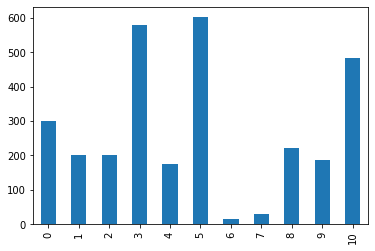

In [16]:
print(all_df.groupby('class').size().reset_index(name='count'))

all_df['class'].value_counts().sort_index().plot(kind='bar')

### Length of Review_Text

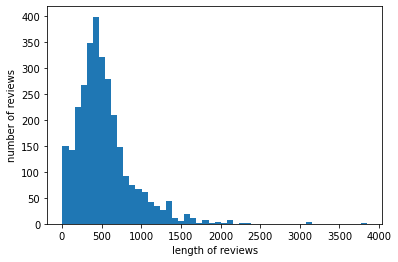

AVG Length : 530.7929309769924


In [17]:
plt.hist([len(r) for r in all_df['review_text']], bins=50)
plt.xlabel('length of reviews')
plt.ylabel('number of reviews')
plt.show()

# Average Length of Reviews
total_len = sum(map(len, all_df['review_text']))
cnt_rvw = len(all_df['review_text'])
print("AVG Length : {}".format(total_len/cnt_rvw))

<br>
====================================================================================
<br>

# Pre-processing

## Set DataFrame for Multi-Class

In [18]:
# multi-class
all_df_cls = all_df.copy()
all_df_cls.head()

,reviewId,category,rating,title,review_text,class,asin
0,shng0,Others,5,Excellent Product,First of all I have 3 60LB dogs whom are welco...,1,NaN
1,shng0,Others,5,Excellent Product,First of all I have 3 60LB dogs whom are welco...,5,NaN
2,shng2,Others,5,Worth the price to save your back!,These stairs are the reason my dog can sleep w...,1,NaN
3,shng2,Others,5,Worth the price to save your back!,These stairs are the reason my dog can sleep w...,5,NaN
4,shng4,Others,5,Excellent Quality and Price,My chihuahua really loves these steps. He has ...,2,NaN


In [19]:
# Convert All review to lower-case
all_df_cls = convert_lowercase(all_df_cls)

## Cleansing Review Text

In [20]:
all_df_cls['corpus_list'] = all_df_cls['review_text'].apply(lambda x : preprocess_review(x))

## Shiny-Word(Single+Multi)

In [21]:
factor_sql = '''
                SELECT *
                FROM `taxonomy.shn_kwd` 
            '''
shiny_factor = bq.select_query(factor_sql)
shiny_factor_list = list( set( shiny_factor['keyword'].tolist() ) )
shiny_express = list(filter(lambda x: len(x.split(' '))>=1 , shiny_factor_list))
shiny_express = [tuple(f.split(' ')) for f in shiny_express]

print('Complimenting Factor : ', shiny_factor.shape)
print('Shiny Express lenth : ', len(shiny_express))

Complimenting Factor :  (297, 2)
Shiny Express lenth :  296


## Stopwords

In [22]:
# Get Stopwords list
filter_sql = '''    
    SELECT
      distinct stopword 
    FROM
      market-analysis-project-91130.taxonomy.stp_wds
    WHERE 1=1
      AND stopword not in ('by', 'to', 'of', 'put', 'together', 'up', 'keep', 'itself', 'very', 'well', 'again', 'others', 'really', 'myself', 'more', 'another', 'nice', 'do', 'done', 'super', 'one', 'no', 'thank');
'''
stopword_df = convert_lowercase(bq.select_query(filter_sql))

# Get words related parts ... except
# part_sql = '''
#     SELECT *
#     FROM market-analysis-project-91130.taxonomy.prt_wds
# '''
# parts_df = convert_lowercase(bq.select_query(part_sql))

stop_words = stopword_df['stopword'].tolist()
print('stop_words :', len(stop_words))

# all_df_cls['corpus_list'] = all_df_cls['review_text'].apply(lambda x : preprocess_stpwds(x, stop_words))

stop_words : 524


## Tokenization

In [23]:
N_POS_TAG   = ['CC','CD','DT','EX','FW','LS','PDT','POS','PRP','PRP$','TO','WDT','WP','WRB']
Y_POS_TAG   = ['JJ','JJR','JJS','MD','IN','NN','NNS','NNP','NNPS','RB','RBR','RBS','RP','UH','VB','VBG','VBD','VBN','VBP','VBZ', 'TO', 'DT']

def tokenized_corpus(df):
    corpus = []
    reviewid = []
    global shiny_word
    shiny_word = []
    shiny_tokenizer = nltk.tokenize.MWETokenizer(shiny_express, separator=' ')
    
    # if you wonder that nltk pos tag
    # nltk.help.upenn_tagset()
    
    for i,v in enumerate(tqdm(df['corpus_list'])):
        try:
            word = []
            reviewid.append(str(df.iloc[i].reviewId)) 
           
            for j in pos_tag(regexp_tokenize(v,"[\w']+")) :
                if (j[1] in Y_POS_TAG ) & (len(j[0])>1)  & (j[0].isascii()):
                    word.append(j[0])
            
            # Shiny Factors
            shiny_tokenizer = nltk.tokenize.MWETokenizer(shiny_express, separator=' ')
            tokenized_string = shiny_tokenizer.tokenize(word)
            
            # Lemmatize
            # tokenized_string = [WordNetLemmatizer().lemmatize(x,pos='v') for x in tokenized_string ]
            for i, x in enumerate(tokenized_string) : 
                if len(x.split(' ')) > 1 : # MWE
                    tmp_x = x.split(' ')
                    tmp_x = [WordNetLemmatizer().lemmatize(y, pos='v') for y in tmp_x ]
                    tokenized_string[i] = " ".join(tmp_x)
                else : # Single
                    tokenized_string[i] = WordNetLemmatizer().lemmatize(x, pos='v')
                    
            # Stop Words
            tokenized_corpus = [s for s in tokenized_string if s not in stop_words]
            
            corpus.append(tokenized_corpus)
            ## corpus.append(" ".join(tokenized_string))
            
            tokenized_shiny = [s for s in tokenized_string if s in shiny_factor_list]
            shiny_word.extend(tokenized_shiny)
        except : 
            pass

    corpus_df = pd.DataFrame({'corpus_list' : corpus,'reviewId' : reviewid})
    
    return corpus_df

In [24]:
print('================ Make Corpus ===============')
corpus_all_df_cls = tokenized_corpus(all_df_cls)

print('============================================')
all_df_cls['corpus_list'] = corpus_all_df_cls['corpus_list']

================ Make Corpus ===============


  0%|          | 0/2999 [00:00<?, ?it/s]

### Keyword Count by Class

In [25]:
# Count Shiny Factor Words
shiny_word_dict = collections.Counter(shiny_word)
shiny_factor['count'] = shiny_factor['keyword'].apply(lambda x : shiny_word_dict[x])
shiny_factor.sort_values(by=['count'], ascending=False).head(10)
# print(collections.Counter(shiny_word))

,factor,keyword,count
154,Assemble,put together,615
96,Assemble,ratchet,460
111,Assemble,easy to assemble,334
74,Quality,very sturdy,311
160,Assemble,easy to put together,304
141,Assemble,allen wrench,228
16,Value,for the price,191
157,Assemble,wrench,153
126,Assemble,set up,152
87,Quality,well make,140


### Keyword Count by Class(Multi-Class)

In [26]:
kwd_cnt_all_df = all_df_cls.groupby('class').agg({'corpus_list':'sum'})
kwd_cnt_all_df['corpus_set'] = kwd_cnt_all_df['corpus_list'].apply(lambda x : list(set(x)))
kwd_cnt_all_df['corpus_list_count'] = kwd_cnt_all_df['corpus_list'].apply(lambda x : len(x))
kwd_cnt_all_df['corpus_set_count'] = kwd_cnt_all_df['corpus_set'].apply(lambda x : len(x))
kwd_cnt_all_df

,corpus_list,corpus_set,corpus_list_count,corpus_set_count
class,,,,
0,"[really, love, bed, easy, to, put, wheel, bett...","[tubs, crook, wait, write, spruce, gel, pack w...",4419,1098
1,"[of, lb, dog, welcome, bed, older, jump, bed, ...","[wait, halfway, no creak, seriously, ring, con...",9629,1769
2,"[chihuahua, really, love, step, neck, problem,...","[exceptionally, wait, halfway, no creak, wrang...",10030,1844
3,"[look, no, best, buy, zinus, smartbase, use, t...","[integrity, exceptionally, lumber, wait, halfw...",28866,2920
4,"[minnie, small, no, way, to, look, window, ord...","[exceptionally, wait, no creak, seriously, mov...",9504,1645
5,"[of, lb, dog, welcome, bed, older, jump, bed, ...","[integrity, exceptionally, lumber, wait, ezpz,...",29610,3181
6,"[exactly, look, good quality, nice appearance,...","[tubs, wait, write, tons, room, long, dent, la...",1099,508
7,"[inherit, kinda, nice, couch, bed, mom, mattre...","[wait, write, gel, room, long, seriously, come...",1657,642
8,"[do, come, snag, seam, panel, hide, bed, love,...","[wait, halfway, seriously, ring, constantly, w...",8962,1613


<br>
====================================================================================
<br>

# Validation

## Load Data

In [27]:
factor_sql = '''
                SELECT *
                FROM `taxonomy.shn_kwd` 
             '''
shn_kwd = bq.select_query(factor_sql)
print(shn_kwd.shape)

shiny_df_list = list( set( shn_kwd['keyword'].tolist() ) )
shiny_express = list(filter(lambda x : len(x.split(' '))>=1 , shiny_df_list))
shiny_express = [tuple(f.split(' ')) for f in shiny_express]

(297, 2)


In [28]:
# Load Data
test_df = all_df_cls[:len(shn_df)].copy()

test_df['shiny_corpus'] = test_df['corpus_list'].apply(lambda x : [s for s in x if s in shiny_df_list ])

test_df['y_class'] = test_df['reviewId'].apply(lambda x : list(test_df[test_df['reviewId']==x]['class']))

## Count Keyword

In [29]:
is_shn_kwd = np.zeros((len(test_df), 10))
shiny_fcator = ['Design','Value','Assemble','Packaging','Quality','Customer Service','Delivery','Brand Comparison','Promised Customer','Others']
ratchet_list = ['small ratchet', 'wing nuts', 'wrench', 'socket wrench', 'ratchet and wrench', 'ratchet tool', 'ratcheting', 'ratchet', 'hatchet', 'hex tool', 'hex wrench', 'mallet', 'allen key', 'allen wrench', 'allen wrench tools', 'bolts']

for i, c_l in enumerate(test_df.corpus_list) :
    for c in c_l : 
        if c in shiny_df_list :
            is_shn_kwd[i][shiny_fcator.index(shn_kwd[shn_kwd['keyword']==c].iloc[0]['factor'])] += 1
            if c in ratchet_list : is_shn_kwd[i][-1] += 1
                
    if is_shn_kwd[i].sum() == 0 : is_shn_kwd[i][int(test_df.loc[i, 'class'])-1] = 1
        
is_shn_kwd = [ np.round(x/x.sum(), 2) for x in is_shn_kwd]

## Predict and Calcurate Accuracy

In [30]:
# predict
test_pred_ratio = pd.DataFrame({'pred_ratio':is_shn_kwd})
test_pred_df = [ list(np.nonzero(x)[0]+1) for x in is_shn_kwd ]
test_pred_class = pd.DataFrame({'pred_class':test_pred_df})

# set DF
rs_shn_kwd = pd.concat([test_df, test_pred_class, test_pred_ratio], axis=1)

# caculate accuracy
for i in range(1, class_cnt) : 
    a = len(rs_shn_kwd[rs_shn_kwd['class']==i])
    b = 0
    for p in rs_shn_kwd[(rs_shn_kwd['class']==i)]['pred_class'] :
        if i in p : b+=1
    print("{} : {:.2f} \t {}/{}".format(i, b/a, b, a))

1 : 0.46 	 92/200
2 : 0.52 	 105/201
3 : 0.89 	 517/580
4 : 0.37 	 65/176
5 : 0.61 	 370/602
6 : 0.62 	 10/16
7 : 0.55 	 17/31
8 : 0.44 	 98/222
9 : 0.41 	 77/188
10 : 0.78 	 377/483


## Confusion Matrix

                   precision    recall  f1-score   support

           Design       0.46      0.54      0.50       169
            Value       0.52      0.48      0.50       221
         Assemble       0.89      0.48      0.62      1087
        Packaging       0.37      0.83      0.51        78
          Quality       0.61      0.75      0.68       493
 Customer Service       0.62      0.71      0.67        14
         Delivery       0.55      0.50      0.52        34
 Brand Comparison       0.44      0.94      0.60       104
Promised Customer       0.41      0.80      0.54        96
           Others       0.78      0.94      0.85       403

         accuracy                           0.64      2699
        macro avg       0.57      0.70      0.60      2699
     weighted avg       0.71      0.64      0.64      2699

[[ 92   8  10   7  20   2   1  11   9   9]
 [ 11 105  12   7  39   1   1  19  10  16]
 [ 77  61 517  74 151   3   9  77  65  53]
 [  3   2   2  65   1   0   0   1   3   1]

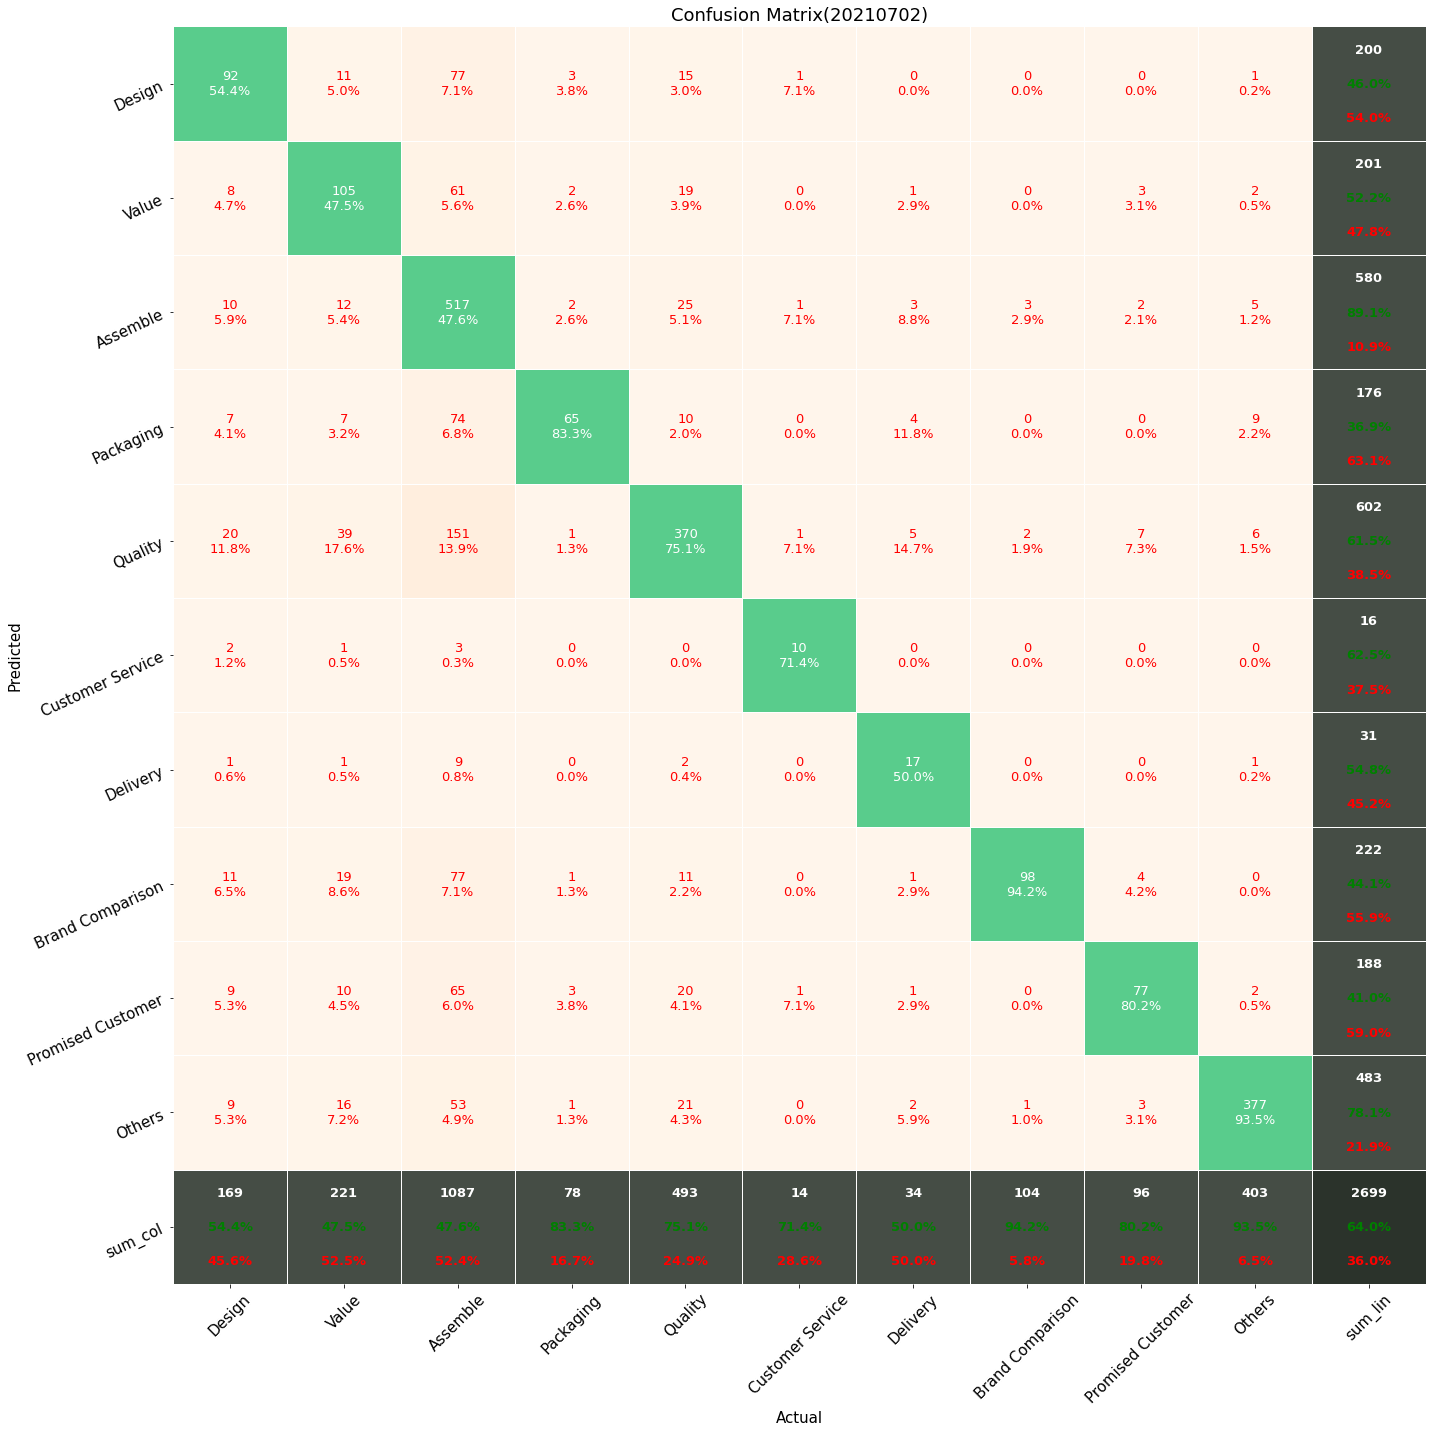

0.6402371248610597

In [31]:
val_aa = rs_shn_kwd.copy()
val_aa['pred_class_cd'] = val_aa['class']
for i in range(len(val_aa)) : 
    if val_aa.loc[i, 'class'] in val_aa.loc[i, 'pred_class'] : 
        val_aa.loc[i, 'pred_class_cd'] = val_aa.loc[i, 'class']
    else : 
        val_aa.loc[i, 'pred_class_cd'] = is_shn_kwd[i].argmax()+1

y_cf_dic = {
            'Design' : 1,
            'Value' : 2,
            'Assemble' : 3,
            'Packaging' : 4,
            'Quality' : 5,
            'Customer Service' : 6,
            'Delivery' : 7,
            'Brand Comparison' : 8,
            'Promised Customer' : 9,
            'Others' : 10
           }

val_df = val_aa.replace({"class": y_cf_dic, "pred_class": y_cf_dic})

y_pred = val_df['class'].tolist()
y_true = val_df['pred_class_cd'].tolist()
target_name = list(y_cf_dic)

print(classification_report(y_true, y_pred, target_names=target_name))

cm=confusion_matrix(y_true,y_pred)
print(cm)

_execute_confusion_matrix(y_true,y_pred)
accuracy_score(y_true,y_pred)

<br>
====================================================================================
<br>

# Visualization(Sample)

## Get ASIN & Reviews

In [32]:
sample_asin_sql = '''
    SELECT asin, count(asin) as cnt
    FROM `market-analysis-project-91130`.taxonomy.positive_keyword_anal
    WHERE 1=1
      AND shiny_factor !=''
      AND yearmonth >= '202104'
    GROUP BY asin
    HAVING COUNT(*) > 0
    ORDER BY cnt desc
'''
sample_asin_df = bq.select_query(sample_asin_sql)

print(sample_asin_df.shape)
sample_asin_df.head()

(4492, 2)


,asin,cnt
0,B00EYN1NEG,51
1,B074QWX9V9,43
2,B01LWT246J,41
3,B00NPVCPRM,40
4,B006MISZOC,38


In [33]:
sample_review_sql = '''
    SELECT
        rvw.asin, pdt.sku, pdt.category, pdt.sub_category, rvw.reviewId, rvw.date, rvw.rating, rvw.title, rvw.review_text
    FROM 
        `crwl.amz_rvw_all` rvw
        right outer join `taxonomy.zinus_product_master` pdt
            on rvw.asin = pdt.asin
    WHERE 1=1
        and date >= '2021-06-01'
        and rating = 5
        -- and rvw.asin in {}
'''
# .format(tuple(top3_asin))

sample_review_df = bq.select_query(sample_review_sql)
sample_review_df['review_text'] = convert_lowercase(sample_review_df[['review_text']])
print(sample_review_df.shape)
sample_review_df.head()

(2821, 9)


,asin,sku,category,sub_category,reviewId,date,rating,title,review_text
0,B075FFFNX4,OLB-NPDBS-39,frames for mattresses,newport db,R1LUKYN73DNOKC,2021-06-08 12:00:00,5,Great for kids rooms,we debated on getting a bunkbed with a futon ...
1,B075FFFNX4,OLB-NPDBS-39,frames for mattresses,newport db,R1MS7JRMHKVVMV,2021-06-26 12:00:00,5,"Very easy assembly, Sturdy. Very nice. Excelle...","love this bed. as far as assembly, it was the..."
2,B075FFFNX4,OLB-NPDBS-39,frames for mattresses,newport db,R3F42TCIGXETW0,2021-06-22 12:00:00,5,Absolutely Perfect !!!,this is the perfect piece of furniture for th...
3,B01MXE2XF1,FCPB-F,frames for mattresses,classic faux leather,R1MWGFNFRUNDH,2021-06-02 12:00:00,5,bed frame,wonderful bed frame.
4,B01MXE2XF1,FCPB-F,frames for mattresses,classic faux leather,R3OKBHG3KR1Q7H,2021-06-09 12:00:00,5,Durable,very easy to assemble and looks great. i got ...


## Pre-processing

In [34]:
# cleansing
sample_review_df['corpus_list'] = sample_review_df['review_text'].apply(lambda x : preprocess_review(x))

# tokenizing
corpus_rvw_df = tokenized_corpus(sample_review_df)
sample_review_df['corpus_list'] = corpus_rvw_df['corpus_list']

sample_review_df.head()

  0%|          | 0/2821 [00:00<?, ?it/s]

,asin,sku,category,sub_category,reviewId,date,rating,title,review_text,corpus_list
0,B075FFFNX4,OLB-NPDBS-39,frames for mattresses,newport db,R1LUKYN73DNOKC,2021-06-08 12:00:00,5,Great for kids rooms,we debated on getting a bunkbed with a futon ...,"[debate, bunkbed, futon, bottom, end, up, inst..."
1,B075FFFNX4,OLB-NPDBS-39,frames for mattresses,newport db,R1MS7JRMHKVVMV,2021-06-26 12:00:00,5,"Very easy assembly, Sturdy. Very nice. Excelle...","love this bed. as far as assembly, it was the...","[love, bed, far, assembly, very, best, easiest..."
2,B075FFFNX4,OLB-NPDBS-39,frames for mattresses,newport db,R3F42TCIGXETW0,2021-06-22 12:00:00,5,Absolutely Perfect !!!,this is the perfect piece of furniture for th...,"[perfect, piece, of, furniture, small, space, ..."
3,B01MXE2XF1,FCPB-F,frames for mattresses,classic faux leather,R1MWGFNFRUNDH,2021-06-02 12:00:00,5,bed frame,wonderful bed frame.,"[wonderful, bed, frame]"
4,B01MXE2XF1,FCPB-F,frames for mattresses,classic faux leather,R3OKBHG3KR1Q7H,2021-06-09 12:00:00,5,Durable,very easy to assemble and looks great. i got ...,"[very, easy to assemble, look great, year, old..."


## Get Shiny Factor&Keyword

In [35]:
new_df = pd.DataFrame(columns=sample_review_df.columns)
new_df['shiny_factor'] = pd.Series()
new_df['shiny_keyword'] = pd.Series()

for i in range(len(sample_review_df)) :
    for c in sample_review_df.iloc[i, -1] : 
        if c in shiny_df_list : 
            new_df.loc[len(new_df)] = np.nan
            new_df.iloc[-1, :-2] = sample_review_df.iloc[i, :]
            new_df.iloc[-1, -2] = shn_kwd[shn_kwd['keyword']==c].iloc[0]['factor']
            new_df.iloc[-1, -1] = c

print(new_df.shape)
new_df.head()

(2271, 12)


,asin,sku,category,sub_category,reviewId,date,rating,title,review_text,corpus_list,shiny_factor,shiny_keyword
0,B075FFFNX4,OLB-NPDBS-39,frames for mattresses,newport db,R1MS7JRMHKVVMV,2021-06-26 12:00:00,5,"Very easy assembly, Sturdy. Very nice. Excelle...","love this bed. as far as assembly, it was the...","[love, bed, far, assembly, very, best, easiest...",Assemble,put together
1,B075FFFNX4,OLB-NPDBS-39,frames for mattresses,newport db,R3F42TCIGXETW0,2021-06-22 12:00:00,5,Absolutely Perfect !!!,this is the perfect piece of furniture for th...,"[perfect, piece, of, furniture, small, space, ...",Quality,very sturdy
2,B075FFFNX4,OLB-NPDBS-39,frames for mattresses,newport db,R3F42TCIGXETW0,2021-06-22 12:00:00,5,Absolutely Perfect !!!,this is the perfect piece of furniture for th...,"[perfect, piece, of, furniture, small, space, ...",Assemble,easy to put together
3,B01MXE2XF1,FCPB-F,frames for mattresses,classic faux leather,R3OKBHG3KR1Q7H,2021-06-09 12:00:00,5,Durable,very easy to assemble and looks great. i got ...,"[very, easy to assemble, look great, year, old...",Assemble,easy to assemble
4,B01MXE2XF1,FCPB-F,frames for mattresses,classic faux leather,R3OKBHG3KR1Q7H,2021-06-09 12:00:00,5,Durable,very easy to assemble and looks great. i got ...,"[very, easy to assemble, look great, year, old...",Design,look great


## Count Keyword

In [36]:
tmp_new_df = new_df.groupby(['asin'])
tmp_new_df = tmp_new_df.size().reset_index(name='counts').sort_values('counts', ascending=False, ignore_index=True)
top_asin = tmp_new_df.loc[0, 'asin']
tmp_new_df.head()

,asin,counts
0,B074QWVHDJ,59
1,B00NPVCPRM,57
2,B06ZZ3XHX5,49
3,B006MISZOC,42
4,B006MIUM20,40


In [37]:
tmp_new_df = new_df.groupby(['asin', 'shiny_factor'])
tmp_new_df.size().reset_index(name='counts').sort_values('counts', ascending=False).head()

,asin,shiny_factor,counts
581,B074QWVHDJ,Assemble,40
59,B00NPVCPRM,Assemble,36
418,B06ZZ3XHX5,Assemble,28
9,B006MISZOC,Assemble,28
13,B006MIUM20,Assemble,28


In [38]:
tmp_new_df = new_df.groupby(['asin', 'shiny_factor', 'shiny_keyword'])
tmp_new_df.size().reset_index(name='counts').sort_values('counts', ascending=False).head()

,asin,shiny_factor,shiny_keyword,counts
34,B006MIUM20,Assemble,easy to assemble,17
19,B006MISZOC,Assemble,easy to assemble,17
139,B00NPVCPRM,Assemble,easy to assemble,16
1112,B074QWVHDJ,Assemble,easy to assemble,14
66,B00EYN1NEG,Assemble,easy to assemble,10


## Chart

### Factor Level

         asin       shiny_factor  fct_counts
0  B074QWVHDJ           Assemble          40
5  B074QWVHDJ            Quality           9
2  B074QWVHDJ             Design           4
6  B074QWVHDJ              Value           3
1  B074QWVHDJ           Delivery           1
3  B074QWVHDJ             Others           1
4  B074QWVHDJ  Promised Customer           1


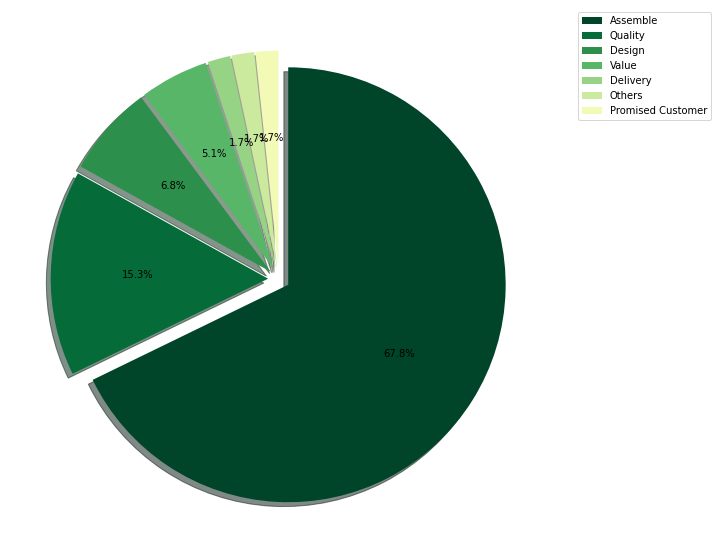

In [39]:
tmp_new_df = new_df[new_df['asin']==top_asin].groupby(['asin', 'shiny_factor'])
tmp_new_df = tmp_new_df.size().reset_index(name='fct_counts').sort_values('fct_counts', ascending=False)
print(tmp_new_df)

fig, ax = plt.subplots(facecolor='white', figsize=(10, 10))
plt.rcParams['text.color'] = 'black'
plt.rcParams['font.size'] = 10
labels = tmp_new_df['shiny_factor'].tolist()
explode = [0.05]*len(labels)

theme = plt.get_cmap('YlGn').reversed() # YlGn, Greens
ax.set_prop_cycle("color", [theme(1. * i / len(tmp_new_df['fct_counts'])) for i in range(len(tmp_new_df['fct_counts']))])

plt.pie(tmp_new_df['fct_counts'],
        explode=explode,
        shadow=True,
        autopct='%1.1f%%',
        startangle=90,
        counterclock=False)
plt.legend(labels, loc='upper left', bbox_to_anchor=(1.04,1))
plt.show()

### Keyword Level

          asin shiny_factor         shiny_keyword  kwd_counts
3   B074QWVHDJ     Assemble      easy to assemble          14
5   B074QWVHDJ     Assemble  easy to put together           7
8   B074QWVHDJ     Assemble               ratchet           5
1   B074QWVHDJ     Assemble          allen wrench           4
4   B074QWVHDJ     Assemble        easy to follow           3
7   B074QWVHDJ     Assemble          put together           2
0   B074QWVHDJ     Assemble             allen key           1
2   B074QWVHDJ     Assemble           easy set up           1
6   B074QWVHDJ     Assemble    great instructions           1
9   B074QWVHDJ     Assemble    simple to assemble           1
10  B074QWVHDJ     Assemble                wrench           1


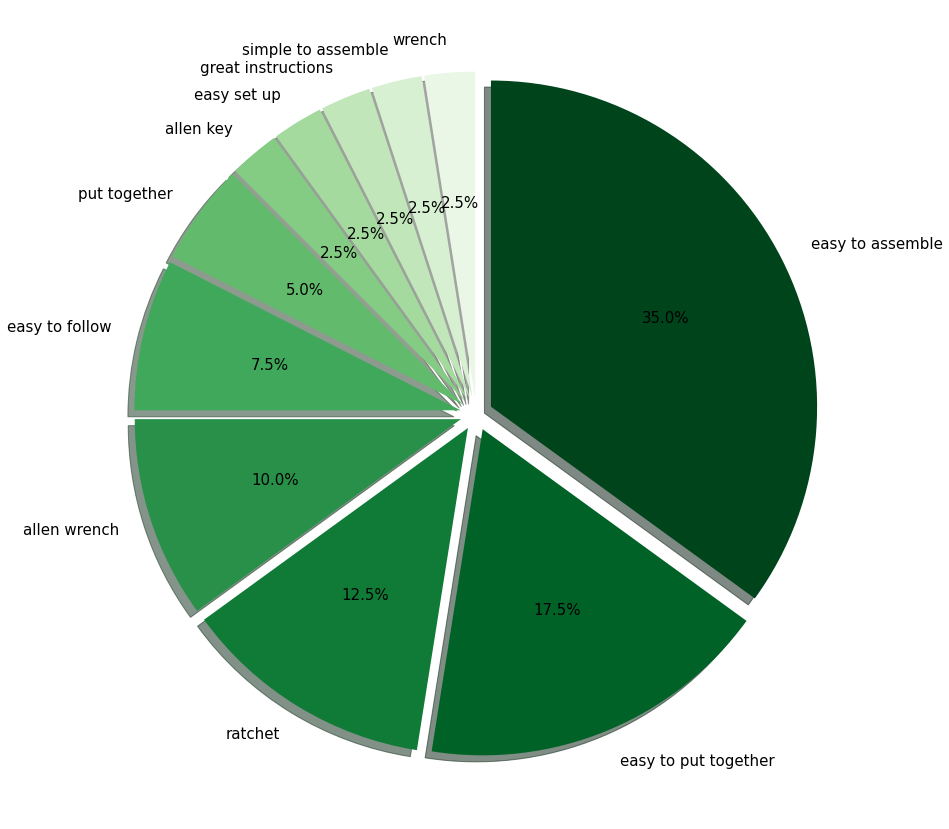

In [40]:
tmp_new_df = new_df[(new_df['asin']==top_asin) & (new_df['shiny_factor']=='Assemble')].groupby(['asin', 'shiny_factor', 'shiny_keyword'])
tmp_new_df = tmp_new_df.size().reset_index(name='kwd_counts').sort_values('kwd_counts', ascending=False)
print(tmp_new_df)

labels = tmp_new_df['shiny_keyword'].tolist()
explode = [0.05]*len(labels)

fig, ax = plt.subplots(facecolor='white', figsize=(15, 15))
plt.rcParams['text.color'] = 'black'
plt.rcParams['font.size'] = 15

theme = plt.get_cmap('Greens').reversed() # YlGn, Greens
ax.set_prop_cycle("color", [theme(1. * i / len(tmp_new_df['kwd_counts'])) for i in range(len(tmp_new_df['kwd_counts']))])

plt.pie(tmp_new_df['kwd_counts'],
        labels=labels,
        explode=explode,
        shadow=True,
        autopct='%1.1f%%',
        startangle=90,
        counterclock=False)
plt.show()